# Project to Detect Lane Lines

## Step 1 - Let's calibrate the camera

First let's print the chessboard images and highlight the corners

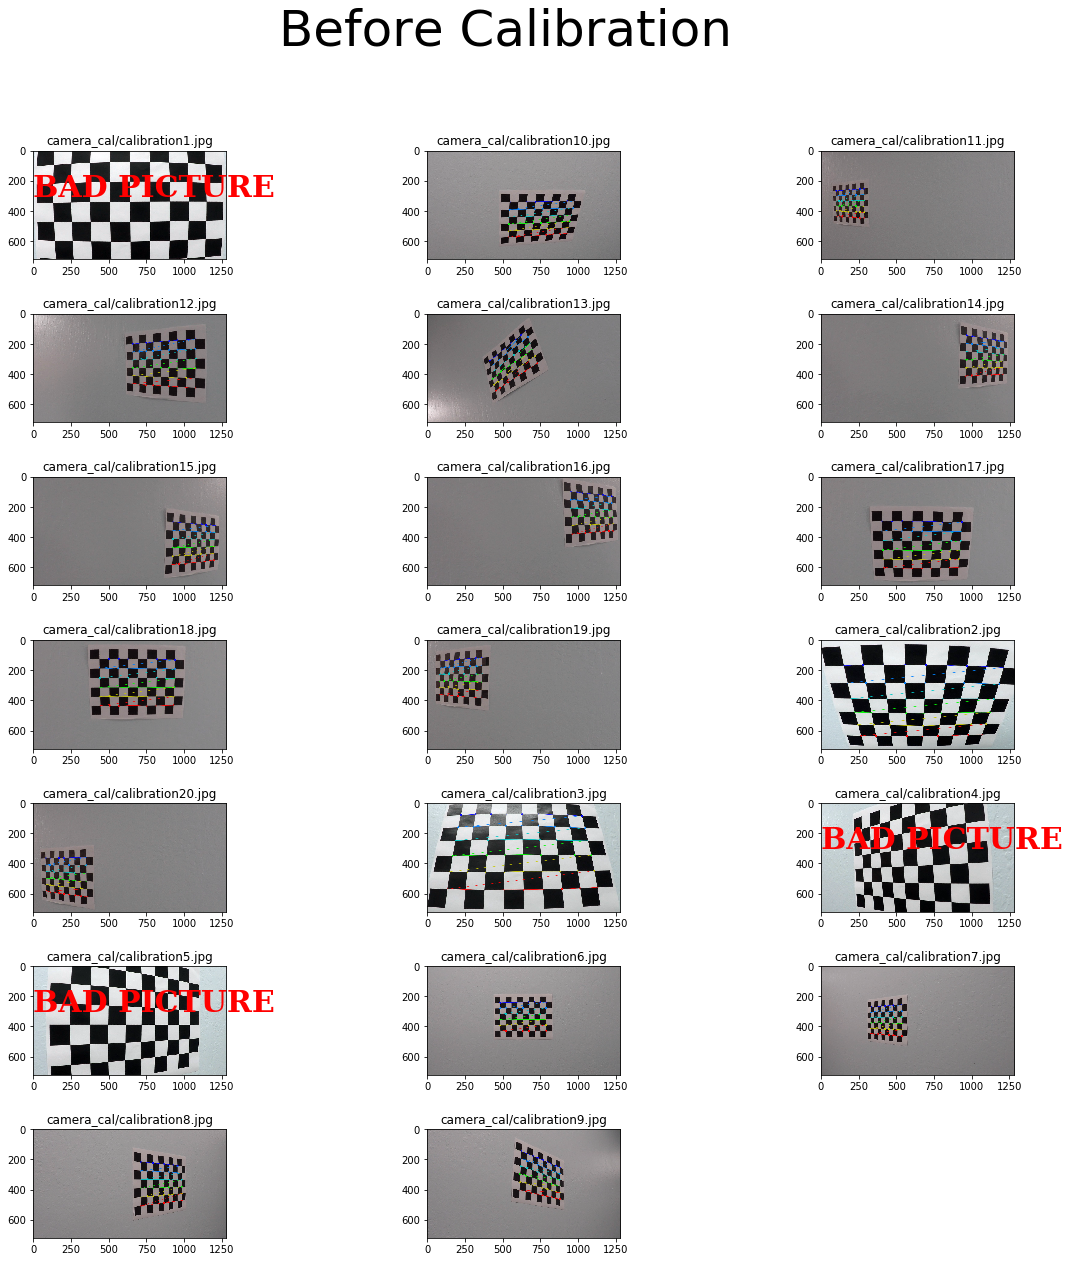

In [17]:
%matplotlib inline

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

pltcolumns = 3
pltrows = math.ceil(len(images) / pltcolumns)

f = plt.figure(figsize=(20,20))
f.suptitle("Before Calibration", fontsize=50)
before_calibration_image_names = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        before_calibration_image_names.append(fname)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        pltspace = plt.subplot(pltrows, pltcolumns, idx + 1)
        plt.subplots_adjust(hspace=0.5)
        pltspace.set_title(fname)
        plt.imshow(img)
    else:
        font = {'family': 'serif',
        'color':  'red',
        'weight': 'heavy',
        'size': 30,
        }
        
        pltspace = plt.subplot(pltrows, pltcolumns, idx + 1)
        plt.subplots_adjust(hspace=0.5)
        pltspace.set_title(fname)
        plt.imshow(img)
        plt.text(0,300, "BAD PICTURE", fontdict=font)

Then, let's take this and send the values to the cv2.calibrateCamera() function

In [18]:
def undistortImage(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

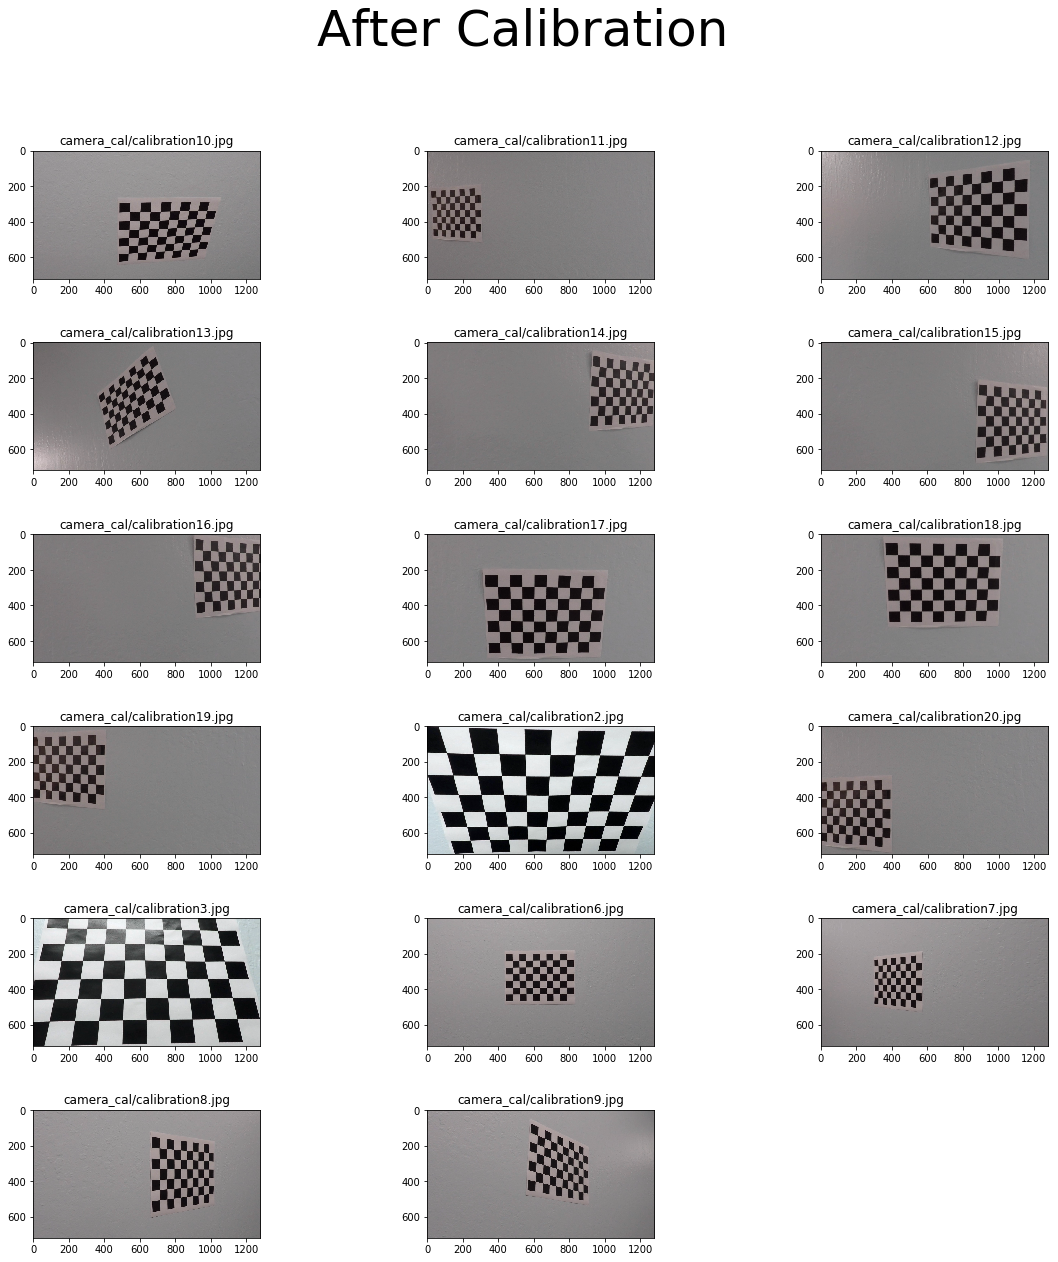

In [19]:
tmp = cv2.imread(before_calibration_image_names[0])
img_size = (tmp.shape[1], tmp.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

f = plt.figure(figsize=(20,20))
f.suptitle("After Calibration", fontsize=50)

pltcolumns = 3
pltrows = math.ceil(len(before_calibration_image_names) / pltcolumns)

for idx, fname in enumerate(before_calibration_image_names):
    img = cv2.imread(fname)
    dst = undistortImage(img, mtx, dist)
    pltspace = plt.subplot(pltrows, pltcolumns, idx + 1)
    plt.subplots_adjust(hspace=0.5)
    pltspace.set_title(fname)
    plt.imshow(dst)

## Step 2 - Image Transformations
In this step, i'll introduce some functions we can use later in the project for detecting road lines in the image

In [20]:
#In this function, I will attempt to isolate the regions that contain some shade of yellow or white
#This is because I am not interested in any other colours when I am detecting a lane.
def getImageMask(img):
    hsvImage = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)#since I am using mpimage
    
    yellow_low = np.array([10,75,100])
    yellow_high = np.array([40,255,255])
    
    yellow_mask = cv2.inRange(hsvImage, yellow_low, yellow_high)
    
    white_low  = np.array([0, 0, 190])
    white_high = np.array([255,25,255])
    
    white_mask = cv2.inRange(hsvImage, white_low, white_high)
    
    combined_mask = cv2.bitwise_or(white_mask, yellow_mask)
    
    return combined_mask

#apply the mask on the image
def applyMask(img, mask):
    return cv2.bitwise_and(img, img, mask = mask)


#apply sobel mask
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    gradX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    gradY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    absGradX = np.absolute(gradX)
    absGradY = np.absolute(gradY)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    tans = np.arctan2(absGradY, absGradX)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gray)
    binary_output[ (tans > thresh[0]) & (tans < thresh[1]) ] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    magitude = np.sqrt(sobelX**2 + sobelY**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(magitude)/255 
    gradmag = (magitude/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def draw_lines2(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        cv2.line(img, (line[0], line[1]), (line[2], line[3]), color, thickness)
        
def debug_draw_region(img, bottom_left, mid_left, mid_right, bottom_right):
    regionLines = np.empty(shape=[0, 4],dtype=int);

    firstLine = np.array([[bottom_left[0],bottom_left[1],mid_left[0],mid_left[1]]], dtype=int);
    secondLine = np.array([[mid_left[0],mid_left[1],mid_right[0],mid_right[1]]], dtype=int);
    thirdLine = np.array([[mid_right[0],mid_right[1],bottom_right[0],bottom_right[1]]], dtype=int);
    fourthLine = np.array([[bottom_right[0],bottom_right[1],bottom_left[0],bottom_left[1]]], dtype=int);

    regionLines = np.concatenate((regionLines, firstLine), axis = 0);
    regionLines = np.concatenate((regionLines, secondLine), axis = 0);
    regionLines = np.concatenate((regionLines, thirdLine), axis = 0);
    regionLines = np.concatenate((regionLines, fourthLine), axis = 0);
    
    return draw_lines2(img, regionLines)

def getROIImage(img):
    width, height = img.shape[1], img.shape[0]
    
    up = 0.61*height;
    bottom_left = (0.10*width, height);
    mid_left = (0.47*width,up);
    mid_right = [0.525*width,up];
    bottom_right = [0.94*width, height];
    
    img_copy = np.copy(img);
    debug_draw_region(img_copy,bottom_left, mid_left, mid_right, bottom_right)
    src = np.array([[bottom_left,mid_left,mid_right,bottom_right]], dtype=np.float32);
    
    dst_height = math.floor(height)
    dst_width = math.floor(width)
    dst_dev_X = 250
    
    dst_bottom_left = (dst_dev_X, dst_height);
    dst_mid_left = (dst_dev_X,0);
    dst_mid_right = [dst_width - dst_dev_X,0];
    dst_bottom_right = [dst_width - dst_dev_X, dst_height];
    
    dst = np.array([[dst_bottom_left,dst_mid_left,dst_mid_right,dst_bottom_right]], dtype=np.float32);
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (dst_width, dst_height))
    return warped, M, img_copy
    

#apply gaussian filter
def applyGaussian(img, kernelSize):
    return cv2.GaussianBlur(img, (kernelSize, kernelSize), 0)

def getCombinedSobelMask(transformedImg):
    sobel_kernel_size = 5

    hsvTransformed = cv2.cvtColor(transformedImg, cv2.COLOR_RGB2HSV);

    s = hsvTransformed[:,:,1]
    v = hsvTransformed[:,:,2] 

    Sgradx = abs_sobel_thresh(s, orient='x', sobel_kernel=sobel_kernel_size, thresh=(15, 255))

    Vgradx = abs_sobel_thresh(v, orient='x', sobel_kernel=sobel_kernel_size, thresh=(15, 255))

    #mag_binary = mag_thresh(s, sobel_kernel=sobel_kernel_size, mag_thresh=(15, 200))
    #dir_binary = dir_threshold(h, sobel_kernel=sobel_kernel_size, thresh=(math.pi/3, math.pi/2))

    mask = getImageMask(transformedImg)
    result = applyMask(transformedImg, mask)
    
    # Plot the result
    combined = np.zeros_like(Sgradx)
    combined[((Sgradx ==1) | (Vgradx == 1) | (mask == 255))] = 1
    
    return combined

In [185]:
from numpy.linalg import inv

class State():
    def __init__(self, inImage):
        # was the line detected in the last iteration?
        self.m_LeftDetected = False 
        self.m_RightDetected = False
        # image stored. Used for diffing
        self.m_Image = inImage
        self.m_OutputImage = None
        # Points stored
        self.m_PointsLeft = []
        self.m_PointsRight = []
        #Curves
        self.curveLeft = None
        self.curveRight = None
        # radius of curvature
        self.m_RadiusOfCurvatureLeft = None
        self.m_RadiusOfCurvatureRight = None
        
    def getCurvature(self, fit_curve, ploty, xvalues):
        #Evaluate it closest to the car at the maximum height in the image
        y_eval = np.max(ploty)
        curverad = ((1 + (2*fit_curve[0]*y_eval + fit_curve[1])**2)**1.5) / np.absolute(2*fit_curve[0])
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 45/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/680 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(ploty*ym_per_pix, xvalues*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        
        print(curverad)
        return curverad
    
    def generateResultImage(self, M, originalImg):
        width, height = originalImg.shape[1], originalImg.shape[0]
        unwarped = np.array((height, width, 3)); #3 colour channels
        inverseM = inv(M)
        unwarped = cv2.warpPerspective(self.m_OutputImage, inverseM, (width, height))
        
        overlayed = cv2.addWeighted(originalImg, 1, unwarped, 0.3, 0)
        
        return overlayed
        
        
    def processState(self, window_width, window_height):
        out_img = np.dstack((self.m_Image, self.m_Image, self.m_Image))*255;
        
        nonZeroXLeft = np.array((0))
        nonZeroYLeft = np.array((0))
        nonZeroXRight = np.array((0))
        nonZeroYRight = np.array((0))
        
        for point in self.m_PointsLeft:
            oppPoint = np.copy(point)
            oppPoint[0] += window_width
            oppPoint[1] -= window_height
            
            cv2.rectangle(out_img, (point[0], point[1]), (oppPoint[0], oppPoint[1]), (0,255,0), 5)
            
            #get the non-zero values here
            nonZeroLeftVals = self.m_Image[oppPoint[1]:point[1], point[0]:oppPoint[0]].nonzero()
            tempLeftX = nonZeroLeftVals[1] + point[0]
            tempLeftY = nonZeroLeftVals[0] + oppPoint[1]
            nonZeroXLeft = np.append(nonZeroXLeft, tempLeftX)
            nonZeroYLeft = np.append(nonZeroYLeft, tempLeftY)            
        
        for point in self.m_PointsRight:
            oppPoint = np.copy(point)
            oppPoint[0] += window_width
            oppPoint[1] -= window_height
            
            cv2.rectangle(out_img, (point[0], point[1]), (oppPoint[0], oppPoint[1]), (0,255,0), 5)
            
            #get the non-zero values here
            nonZeroRightVals = self.m_Image[oppPoint[1]:point[1], point[0]:oppPoint[0]].nonzero()
            tempRightX = nonZeroRightVals[1] + point[0]
            tempRightY = nonZeroRightVals[0] + oppPoint[1]
            nonZeroXRight = np.append(nonZeroXRight, tempRightX)
            nonZeroYRight = np.append(nonZeroYRight, tempRightY)
        
        left_fit = np.polyfit(nonZeroYLeft, nonZeroXLeft, 2)
        right_fit = np.polyfit(nonZeroYRight, nonZeroXRight, 2)
        
        self.curveLeft = left_fit;
        self.curveRight = right_fit;
        
        ploty = np.linspace(0, self.m_Image.shape[0]-1, self.m_Image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        #Draw the points detected in the window
        out_img[nonZeroYLeft, nonZeroXLeft] = [255, 0, 0]
        out_img[nonZeroYRight, nonZeroXRight] = [0, 0, 255]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = window_width
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        window_img = np.zeros_like(out_img)
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
                
        #Get the curvature in the world space
        self.m_RadiusOfCurvatureLeft = self.getCurvature(left_fit, ploty, left_fitx)
        self.m_RadiusOfCurvatureRight = self.getCurvature(right_fit, ploty, right_fitx)
        
        #Draw the image out
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        mpimg.imsave("output.jpg", out_img)
        self.m_OutputImage = out_img
        
def getBestPoint(maskImage, window_width, window_height, window_start_y, window_start_x, max_deviation_x, threshold_factor=0.02):
    # let's create a sample image
    imgHeight, imgWidth = maskImage.shape[0], maskImage.shape[1]
    
    #lets create a simple image where we store the window data
    windowImg = np.ones((window_height, window_width), dtype=np.uint32)
    
    #this is the y value we iterate over
    y = window_start_y
    
    #let's get the boundaries of searching for the mask image
    startX = max(window_start_x - max_deviation_x, 0)
    endX = min(window_start_x + max_deviation_x, imgWidth - window_width)
    
    #boundaries of the window in the Y axis
    startY = max(window_start_y - window_height, 0)
    endY = window_start_y
    
    best_value = -1
    best_coordinate = -1
    
    last_coordinate = int(-1)
    num_consecutive_best_coordinate = 0
    
    #at least 'threshold_factor' of the pixels should be activated.
    threshold_value = math.ceil(window_width*window_height*threshold_factor)
    
    #now slide the windowImg across the mask image
    for x in range(startX, endX):
        mask_window = maskImage[ startY:endY, x: x+window_width ]
        result = windowImg & mask_window
        
        maskSum = np.sum(result)
        
        if((maskSum > best_value) & (maskSum > threshold_value)):
            best_coordinate = x
            best_value = maskSum
        
        #In this case, I have an optimization
        #If we encounter the same value consecutively I take the average of it in order improve the fitting 
        elif( (maskSum == best_value) & (x - last_coordinate == 1) ):
            num_consecutive_best_coordinate += 1
            ranges = np.arange(x-num_consecutive_best_coordinate, x)
            best_coordinate = math.floor(np.average(ranges))
        
        else:
            num_consecutive_best_coordinate = 0
        
        last_coordinate = x
            
    return best_coordinate
        

def detectLanes(combinedSobelMask, lastState, forceSearch):
    
    currentState = State(combinedSobelMask)
    
    #performing for the first time
    if(lastState.m_Image == None):
        forceSearch = True
    else:
        #Diff against the last frame
        diff = np.zeros_like(lastState.image)
        diff = cv2.bitwise_xor(lastState.m_Image, currentState.m_Image)
    
    if(forceSearch):
        #Let's get the histogram of the bottom part of the image. 
        #This will tell us where we have the highest concentration of lines/edges
        histogram = np.sum(combinedSobelMask[combinedSobelMask.shape[0]/2:,:], axis=0)
        
        #Divide the histogram in 2 parts, left and right and let's find the maximum in each
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        numWindows = 10
        maskImageHeight = currentState.m_Image.shape[0]
        maskImageWidth = currentState.m_Image.shape[1]
        window_width = math.floor(maskImageWidth / 10)
        window_height = math.floor(maskImageHeight / numWindows)

        max_deviation_x = 75
        
        #let's consider left images first
        #since leftx_base is the midpoint, let's get the left value of the rect
        lastPointLeft = leftx_base - math.floor(window_width / 2)
        
        failCounter = 0
        max_fail_attempts = 2
        removal_amount = (max_fail_attempts - 1)
        
        for windowNum in range(numWindows):
            window_start_y = maskImageHeight - ( windowNum * window_height )
            window_start_x = lastPointLeft
            
            currentBestLeft = getBestPoint(currentState.m_Image, window_width, window_height, window_start_y, window_start_x, max_deviation_x)
            
            #If we find a best point, then that should be the new lastPoint, else let's take the previous last point
            if((currentBestLeft >= 0) & (currentBestLeft <= (maskImageWidth - window_width))):
                lastPointLeft = currentBestLeft
                failCounter = 0
            else:
                failCounter+=1
                if( failCounter == max_fail_attempts):
                    #if we fail 'max_fail_attempts' times in a row, delete the last 'removal_amount' points and end
                    currentState.m_PointsLeft = currentState.m_PointsLeft[:-removal_amount]
                    break
                if ((lastPointLeft <= max_deviation_x) | (lastPointLeft >= (maskImageWidth - max_deviation_x))):
                    break
                    
            point = [lastPointLeft, window_start_y]
            currentState.m_PointsLeft.append(point)
              
        #Same thing for the right side now
        lastPointRight = rightx_base - math.floor(window_width / 2)
        failCounter = 0
        
        for windowNum in range(numWindows):
            window_start_y = maskImageHeight - ( windowNum * window_height )
            window_start_x = lastPointRight
            
            currentBestRight = getBestPoint(currentState.m_Image, window_width, window_height, window_start_y, window_start_x, max_deviation_x)
            
            #If we find a best point, then that should be the new lastPoint, else let's take the previous last point
            if((currentBestRight >= 0) & (currentBestRight <= (maskImageWidth - window_width))):
                lastPointRight = currentBestRight
                failCounter = 0
            else:
                failCounter+=1
                if( failCounter == max_fail_attempts):
                    #if we fail 'max_fail_attempts' times in a row, delete the last 'removal_amount' points and end
                    currentState.m_PointsRight = currentState.m_PointsRight[:-removal_amount]
                    break
                if ((lastPointRight <= max_deviation_x) | (lastPointRight >= (maskImageWidth - max_deviation_x))):
                    break
                    
            point = [lastPointRight, window_start_y]
            currentState.m_PointsRight.append(point)
        
        currentState.processState(window_width, window_height)
    
    return currentState


def debugDraw(originalImg, areaSelectionImg, transformedImg, combinedSobelMask, s, finalImg):
    f, axarr = plt.subplots(3, 2, figsize=(24, 20))
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    axarr[0][0].set_title('Original Image')
    axarr[0][0].imshow(originalImg)
    
    axarr[0][1].set_title('Area Selection Image')
    axarr[0][1].imshow(areaSelectionImg)
    
    axarr[1][0].set_title('Transformed Image')
    axarr[1][0].imshow(transformedImg)
    
    axarr[1][1].set_title('Combined Sobel Image')
    axarr[1][1].imshow(combinedSobelMask, cmap='gray')
    
    axarr[2][0].set_title('State Image')
    axarr[2][0].imshow(s.m_OutputImage)
    
    axarr[2][1].set_title('Final Image')
    axarr[2][1].imshow(finalImg)
    
    
    
            

/Users/sachit/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:198: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


408.281576949
421.96044608


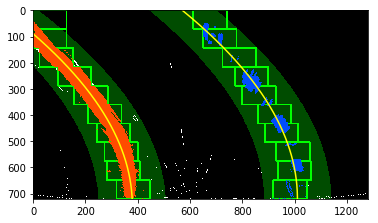

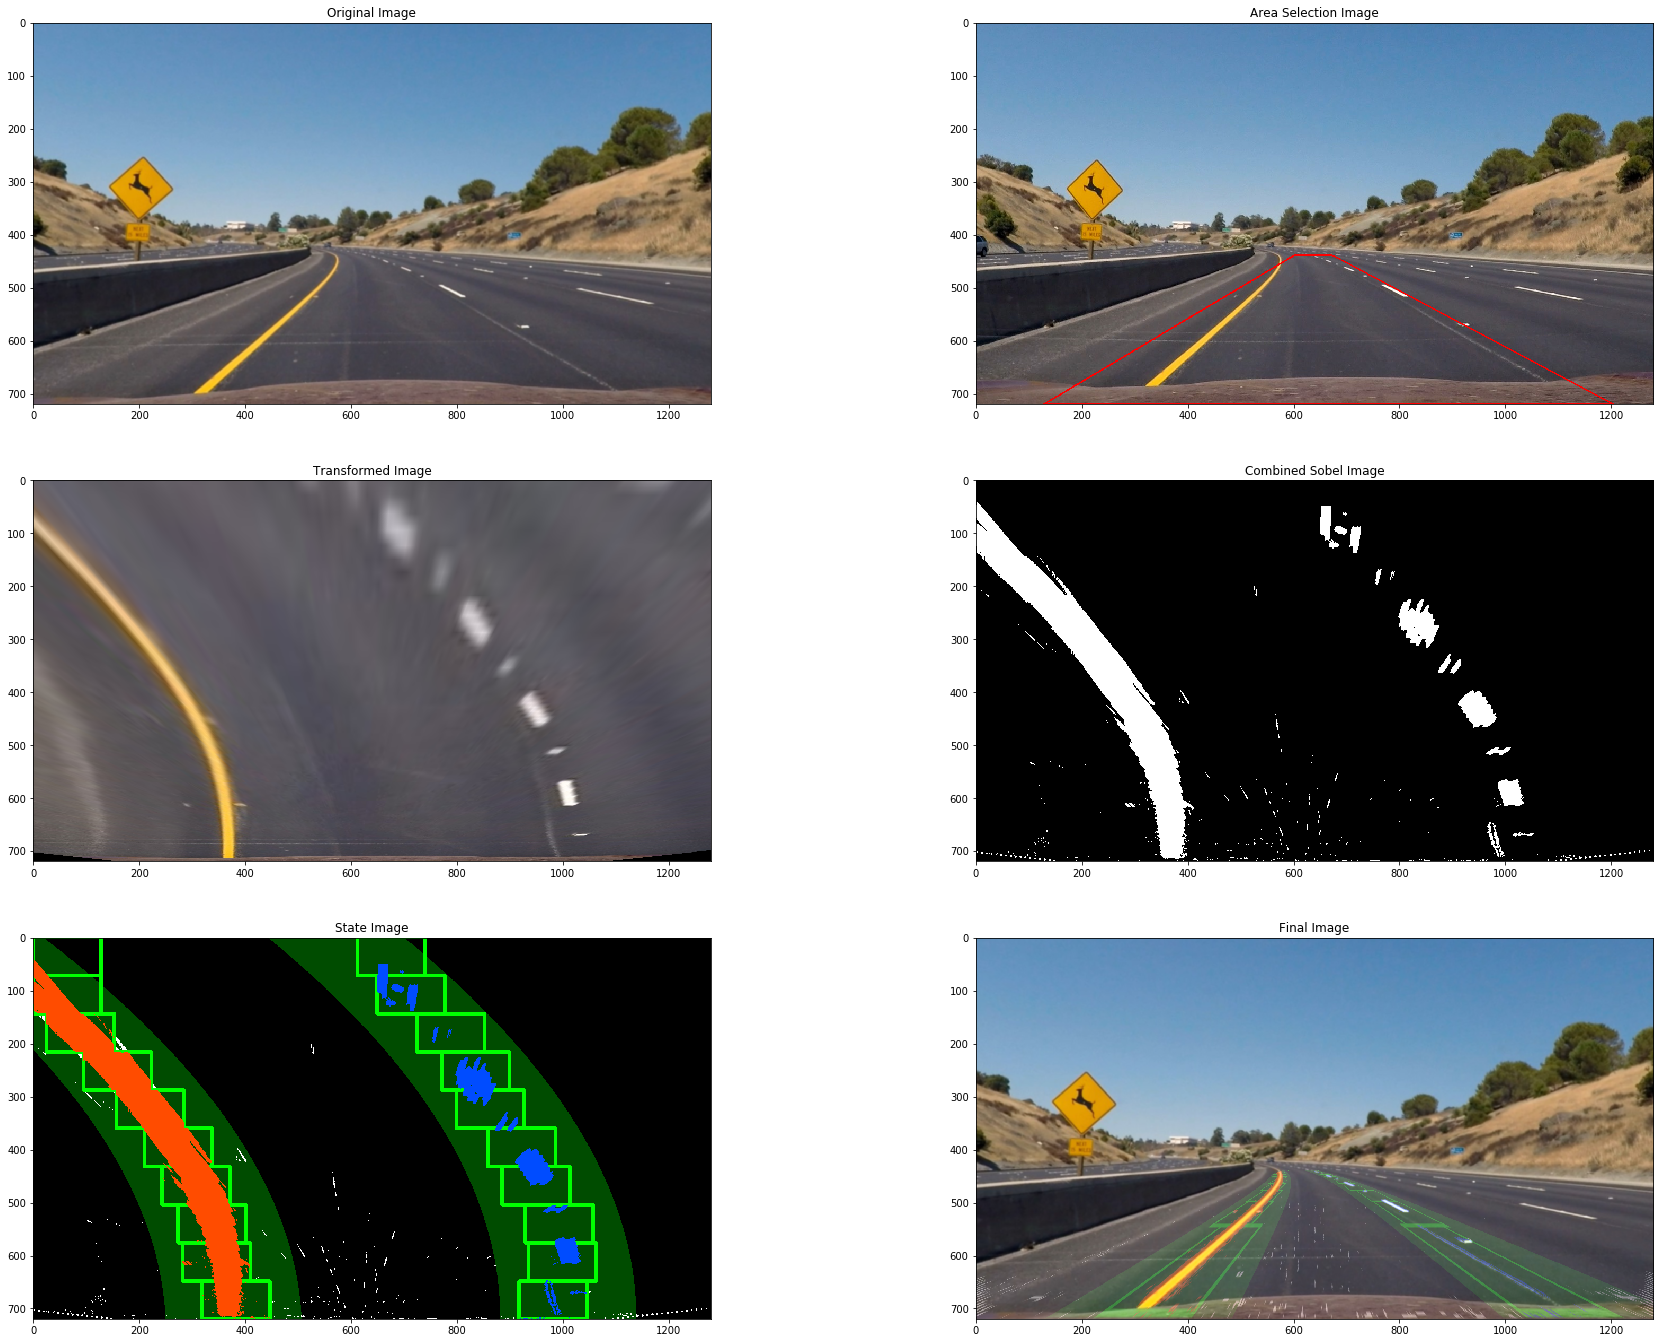

In [186]:
import matplotlib.image as mpimg

img = mpimg.imread("test_images/test2.jpg")

#Undistort the Image
originalImg = undistortImage(img, mtx, dist)

#Let's pass it through a low pass filter to eliminate some noise
gKernelSize = 5
originalImg = applyGaussian(originalImg, gKernelSize)

#Let's get the region of interest, aka the part we care about
transformedImg, transM, areaSelectionImg = getROIImage(img)

#Let's compute the Sobel Mask to detect the edges and combine it with the colour mask to choose the lane lines
combinedSobelMask = getCombinedSobelMask(transformedImg)

#Detect Lanes now
s = detectLanes(combinedSobelMask, State(None), True)

#Generat the final image
finalImg = s.generateResultImage(transM, originalImg)

#Some Debug Draw Stuff to help visualize what's going on.
debugDraw(originalImg, areaSelectionImg, transformedImg, combinedSobelMask, s, finalImg)